In [ ]:
import ray

#We added this code just to check if we are on the correct number of nodes
if not ray.is_initialized():
    ray.init()

nodes = ray.nodes()
print(f"Number of nodes: {len(nodes)}")

for node in nodes:
    print(f"Node ID: {node['NodeID']} | Address: {node['NodeManagerAddress']}")

2025-12-22 15:50:42,766	INFO worker.py:1821 -- Connecting to existing Ray cluster at address: 172.16.66.116:6379...
2025-12-22 15:50:42,778	INFO worker.py:2007 -- Connected to Ray cluster.


Number of nodes: 1
Node ID: 9b9312eec818d24056608a3f102323b96f3a3ee8018575397cddce1d | Address: 172.16.66.116


/home/etalbi/miniconda3/envs/rllib_study/lib/python3.10/site-packages/ray/_private/worker.py:2046: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
(raylet) [2025-12-22 15:50:49,129 E 2453601 2453601] (raylet) main.cc:1032: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


In [ ]:
import ray
from ray.rllib.algorithms.ppo import PPOConfig
import time
import pandas as pd

if ray.is_initialized():
    ray.shutdown()

ray.init() 

print(f" Single-Node Check: {len(ray.nodes())} Node detected.")
print(f" Available CPUs: {ray.cluster_resources().get('CPU')}")

baseline_config = (
    PPOConfig()
    .environment("LunarLander-v3")
    .env_runners(
        num_env_runners=16, 
        num_cpus_per_env_runner=1
    )
    .framework("torch")
    .training(
        train_batch_size=2000, 
        minibatch_size=128,        
        num_sgd_iter=10
    )
)

ppo_trainer = baseline_config.build()
training_history = []

print("\n--- Starting 1-Node Baseline (30 Iterations) ---")
for iteration in range(30):
    start_wall_time = time.time()
    train_results = ppo_trainer.train()
    iteration_duration = time.time() - start_wall_time
    
    runner_stats = train_results.get("env_runners", {})
    mean_reward = runner_stats.get("episode_return_mean", train_results.get("episode_reward_mean", 0.0))
    cumulative_steps = train_results.get("num_env_steps_sampled_lifetime", 0)
    
    if iteration > 0:
        steps_this_iter = cumulative_steps - training_history[-1]["total_steps"]
        throughput_rate = steps_this_iter / iteration_duration
    else:
        throughput_rate = runner_stats.get("num_env_steps_sampled_per_second", 0.0)

    print(f"Iter {iteration:2}: Total Steps={cumulative_steps:6} | Speed={throughput_rate:6.1f} steps/s | Reward={mean_reward:6.1f}")
    
    training_history.append({
        "iter": iteration, 
        "throughput": throughput_rate, 
        "reward": mean_reward, 
        "total_steps": cumulative_steps
    })

pd.DataFrame(training_history).to_csv("baseline_1node.csv", index=False)
ppo_trainer.stop()
print("\n Baseline complete. Results saved to 'baseline_1node.csv'")

2025-12-22 15:51:12,326	INFO worker.py:1821 -- Connecting to existing Ray cluster at address: 172.16.66.116:6379...
2025-12-22 15:51:12,332	INFO worker.py:2007 -- Connected to Ray cluster.
2025-12-22 15:51:12,349	WARNING algorithm_config.py:2528 -- DeprecationWarning: `config.training(num_sgd_iter=..)` has been deprecated. Use `config.training(num_epochs=..)` instead. This will raise an error in the future!
2025-12-22 15:51:12,349	WARNING 2703674669.py:31 -- DeprecationWarning: `build` has been deprecated. Use `AlgorithmConfig.build_algo` instead. This will raise an error in the future!
2025-12-22 15:51:12,351	WARNING algorithm_config.py:5118 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guid

 Single-Node Check: 1 Node detected.
 Available CPUs: 36.0


(SingleAgentEnvRunner pid=2454111) /home/etalbi/miniconda3/envs/rllib_study/lib/python3.10/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
(SingleAgentEnvRunner pid=2454111)   from pkg_resources import resource_stream, resource_exists
(SingleAgentEnvRunner pid=2454111) [2025-12-22 15:51:16,628 E 2454111 2454179] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(SingleAgentEnvRunner pid=2454111) DeprecationWarning: `RLModule(config=[RLModuleConfig object])` has been deprecated. Use `RLModule(observation_space=.., action_space=.., inference_only=.., model_config=.., catalog_class=..)` instead


--- Starting 1-Node Baseline (30 Iterations) ---
Iter  0: Total Steps=2000.0 | Speed=   0.0 steps/s | Reward=-153.2


/home/etalbi/miniconda3/envs/rllib_study/lib/python3.10/site-packages/ray/rllib/utils/metrics/stats/ema.py:124: RuntimeWarning: Mean of empty slice
  return np.nanmean(self._values_to_merge)


Iter  1: Total Steps=4000.0 | Speed= 946.7 steps/s | Reward=-181.6
Iter  2: Total Steps=6000.0 | Speed= 957.4 steps/s | Reward=-159.8
Iter  3: Total Steps=8000.0 | Speed= 939.5 steps/s | Reward=-127.4
Iter  4: Total Steps=10000.0 | Speed= 952.5 steps/s | Reward=-111.3
Iter  5: Total Steps=12000.0 | Speed= 954.5 steps/s | Reward=-103.4
Iter  6: Total Steps=14000.0 | Speed= 950.9 steps/s | Reward=-102.2
Iter  7: Total Steps=16000.0 | Speed= 961.2 steps/s | Reward=-123.1
Iter  8: Total Steps=18000.0 | Speed= 961.1 steps/s | Reward= -90.5
Iter  9: Total Steps=20000.0 | Speed= 860.7 steps/s | Reward=-117.1


[2025-12-22 15:51:42,351 E 2454056 2456220] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


Iter 10: Total Steps=22000.0 | Speed= 950.6 steps/s | Reward= -99.4
Iter 11: Total Steps=24000.0 | Speed= 946.0 steps/s | Reward= -96.8
Iter 12: Total Steps=26000.0 | Speed= 945.9 steps/s | Reward= -90.3
Iter 13: Total Steps=28000.0 | Speed= 958.1 steps/s | Reward= -88.4
Iter 14: Total Steps=30000.0 | Speed= 958.8 steps/s | Reward= -89.7
Iter 15: Total Steps=32000.0 | Speed= 965.7 steps/s | Reward= -69.2
Iter 16: Total Steps=34000.0 | Speed= 938.5 steps/s | Reward= -48.1
Iter 17: Total Steps=36000.0 | Speed= 962.6 steps/s | Reward= -47.2
Iter 18: Total Steps=38000.0 | Speed= 943.6 steps/s | Reward= -43.9
Iter 19: Total Steps=40000.0 | Speed= 966.4 steps/s | Reward= -53.9
Iter 20: Total Steps=42000.0 | Speed= 952.8 steps/s | Reward= -39.8
Iter 21: Total Steps=44000.0 | Speed= 957.1 steps/s | Reward= -55.4
Iter 22: Total Steps=46000.0 | Speed= 982.4 steps/s | Reward= -61.9
Iter 23: Total Steps=48000.0 | Speed= 928.8 steps/s | Reward=-118.2
Iter 24: Total Steps=50000.0 | Speed= 874.3 step

In [ ]:
import ray
#We added this code because we had to check if the number of nodes
# was correctly taken into consideration.
if not ray.is_initialized():
    ray.init()

nodes = ray.nodes()
print(f"Number of nodes: {len(nodes)}")

for node in nodes:
    print(f"Node ID: {node['NodeID']} | Address: {node['NodeManagerAddress']}")

2025-12-22 15:29:47,702	INFO worker.py:1821 -- Connecting to existing Ray cluster at address: 172.16.66.116:6379...
2025-12-22 15:29:47,714	INFO worker.py:2007 -- Connected to Ray cluster.


Number of nodes: 2
Node ID: 7177e3d98c431e43b5c58e06a1ef6e04dd83345676bb95d80c13e7b0 | Address: 172.16.66.118
Node ID: 21b8e89a87eae9790a9bdde0bb67780811570783605e785470a5e982 | Address: 172.16.66.116


/home/etalbi/miniconda3/envs/rllib_study/lib/python3.10/site-packages/ray/_private/worker.py:2046: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
(pid=9032) [2025-12-22 15:30:21,649 E 9032 9201] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
[2025-12-22 15:30:21,964 E 8969 9030] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


In [ ]:
import ray
from ray.rllib.algorithms.ppo import PPOConfig
import time
import pandas as pd

#Here we followed the same code structure as before but the number of nodes and other variables were changed adequately

if ray.is_initialized():
    ray.shutdown()

ray.init(address="auto")

print(f" Cluster Check: {len(ray.nodes())} Nodes detected.")
print(f" Total CPUs in Cluster: {ray.cluster_resources().get('CPU')}")

# We do the same baseline configuration but configure it for two nodes.
distributed_config = (
    PPOConfig()
    .environment("LunarLander-v3")
    .env_runners(
        num_env_runners=32,            
        num_cpus_per_env_runner=1,
    )
    .framework("torch")
    .training(
        train_batch_size=8000, # Increased batch size to 8000 as explained in report
        minibatch_size=512,            
        num_sgd_iter=10                    
    )
    .resources(
        num_cpus_for_main_process=2       
    )
)

ppo_distributed_trainer = distributed_config.build()
scaling_history = []

print("\n--- Starting High-Performance 2-Node Test (30 Iterations) ---")
for iteration in range(30):
    start_wall_time = time.time()
    train_results = ppo_distributed_trainer.train()
    iteration_duration = time.time() - start_wall_time
    
    runner_stats = train_results.get("env_runners", {})
    mean_reward = runner_stats.get("episode_return_mean", 0.0)
    cumulative_steps = train_results.get("num_env_steps_sampled_lifetime", 0)
    
    if iteration > 0:
        steps_this_iter = cumulative_steps - scaling_history[-1]["total_steps"]
        throughput_rate = steps_this_iter / iteration_duration
    else:
        throughput_rate = 0.0

    if throughput_rate == 0: 
        throughput_rate = runner_stats.get("num_env_steps_sampled_per_second", 0.0)

    print(f"Iter {iteration:2}: Total Steps={cumulative_steps:6} | Speed={throughput_rate:6.1f} steps/s | Reward={mean_reward:6.1f} | Time={iteration_duration:4.1f}s")
    
    scaling_history.append({
        "iter": iteration, 
        "throughput": throughput_rate, 
        "reward": mean_reward, 
        "total_steps": cumulative_steps
    })

pd.DataFrame(scaling_history).to_csv("scaling_2nodes_final.csv", index=False)
ppo_distributed_trainer.stop()

2025-12-22 15:41:40,341	INFO worker.py:1821 -- Connecting to existing Ray cluster at address: 172.16.66.116:6379...
2025-12-22 15:41:40,347	INFO worker.py:2007 -- Connected to Ray cluster.
2025-12-22 15:41:40,368	WARNING algorithm_config.py:2528 -- DeprecationWarning: `config.training(num_sgd_iter=..)` has been deprecated. Use `config.training(num_epochs=..)` instead. This will raise an error in the future!


 Cluster Check: 2 Nodes detected.
 Total CPUs in Cluster: 72.0


(SingleAgentEnvRunner pid=2441821) /home/etalbi/miniconda3/envs/rllib_study/lib/python3.10/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
(SingleAgentEnvRunner pid=2441821)   from pkg_resources import resource_stream, resource_exists
(SingleAgentEnvRunner pid=2441821) DeprecationWarning: `RLModule(config=[RLModuleConfig object])` has been deprecated. Use `RLModule(observation_space=.., action_space=.., inference_only=.., model_config=.., catalog_class=..)` instead. This will raise an error in the future!
2025-12-22 15:41:48,260	WARNING util.py:61 -- Install gputil for GPU system monitoring.



--- Starting High-Performance 2-Node Test (30 Iterations) ---
Iter  0: Total Steps=8000.0 | Speed=   0.0 steps/s | Reward=-186.7 | Time= 3.0s
Iter  1: Total Steps=16000.0 | Speed=2914.8 steps/s | Reward=-156.0 | Time= 2.7s
Iter  2: Total Steps=24000.0 | Speed=2675.3 steps/s | Reward=-145.0 | Time= 3.0s
Iter  3: Total Steps=32000.0 | Speed=2732.2 steps/s | Reward=-118.1 | Time= 2.9s
Iter  4: Total Steps=40000.0 | Speed=2678.1 steps/s | Reward=-123.1 | Time= 3.0s
Iter  5: Total Steps=48000.0 | Speed=2928.9 steps/s | Reward= -99.6 | Time= 2.7s
Iter  6: Total Steps=56000.0 | Speed=2668.3 steps/s | Reward= -75.5 | Time= 3.0s


[2025-12-22 15:42:10,369 E 8969 2441793] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


Iter  7: Total Steps=64000.0 | Speed=2839.5 steps/s | Reward= -62.9 | Time= 2.8s


(SingleAgentEnvRunner pid=2441821) [2025-12-22 15:42:12,712 E 2441821 2441870] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(SingleAgentEnvRunner pid=2441839) /home/etalbi/miniconda3/envs/rllib_study/lib/python3.10/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81. [repeated 31x across cluster]
(SingleAgentEnvRunner pid=2441839)   from pkg_resources import resource_stream, resource_exists [repeated 31x across cluster]
(SingleAgentEnvRunner pid=2441839) DeprecationWarning: `RLModule(config=[RLModuleConfig object])` has been deprecated. Use `RLModule(observation_space=.., action_space=.., in

Iter  8: Total Steps=72000.0 | Speed=2586.8 steps/s | Reward= -61.1 | Time= 3.1s
Iter  9: Total Steps=80000.0 | Speed=2886.2 steps/s | Reward= -54.7 | Time= 2.8s
Iter 10: Total Steps=88000.0 | Speed=2647.3 steps/s | Reward= -36.2 | Time= 3.0s
Iter 11: Total Steps=96000.0 | Speed=2867.0 steps/s | Reward= -37.5 | Time= 2.8s
Iter 12: Total Steps=104000.0 | Speed=2715.5 steps/s | Reward= -25.6 | Time= 2.9s
Iter 13: Total Steps=112000.0 | Speed=2953.9 steps/s | Reward= -12.3 | Time= 2.7s
Iter 14: Total Steps=120000.0 | Speed=2663.9 steps/s | Reward= -17.8 | Time= 3.0s
Iter 15: Total Steps=128000.0 | Speed=2938.9 steps/s | Reward=  -2.2 | Time= 2.7s
Iter 16: Total Steps=136000.0 | Speed=2675.9 steps/s | Reward= -25.7 | Time= 3.0s
Iter 17: Total Steps=144000.0 | Speed=2892.1 steps/s | Reward=  -1.7 | Time= 2.8s
Iter 18: Total Steps=152000.0 | Speed=2642.4 steps/s | Reward=  45.0 | Time= 3.0s
Iter 19: Total Steps=160000.0 | Speed=2733.5 steps/s | Reward=  20.3 | Time= 2.9s
Iter 20: Total Steps

In [ ]:
import ray
from pprint import pprint

nodes = ray.nodes()
print(f"Total Nodes: {len(nodes)}")

for node in nodes:
    resources = node.get("Resources", {})
    print(f"Node: {node['NodeManagerAddress']} | Total CPUs: {resources.get('CPU')}")

# we check the current usage
pprint(ray.cluster_resources())

Total Nodes: 2
Node: 172.16.66.118 | Total CPUs: 36.0
Node: 172.16.66.116 | Total CPUs: 36.0
{'CPU': 72.0,
 'memory': 138585380865.0,
 'node:172.16.66.116': 1.0,
 'node:172.16.66.118': 1.0,
 'node:__internal_head__': 1.0,
 'object_store_memory': 59393734655.0}


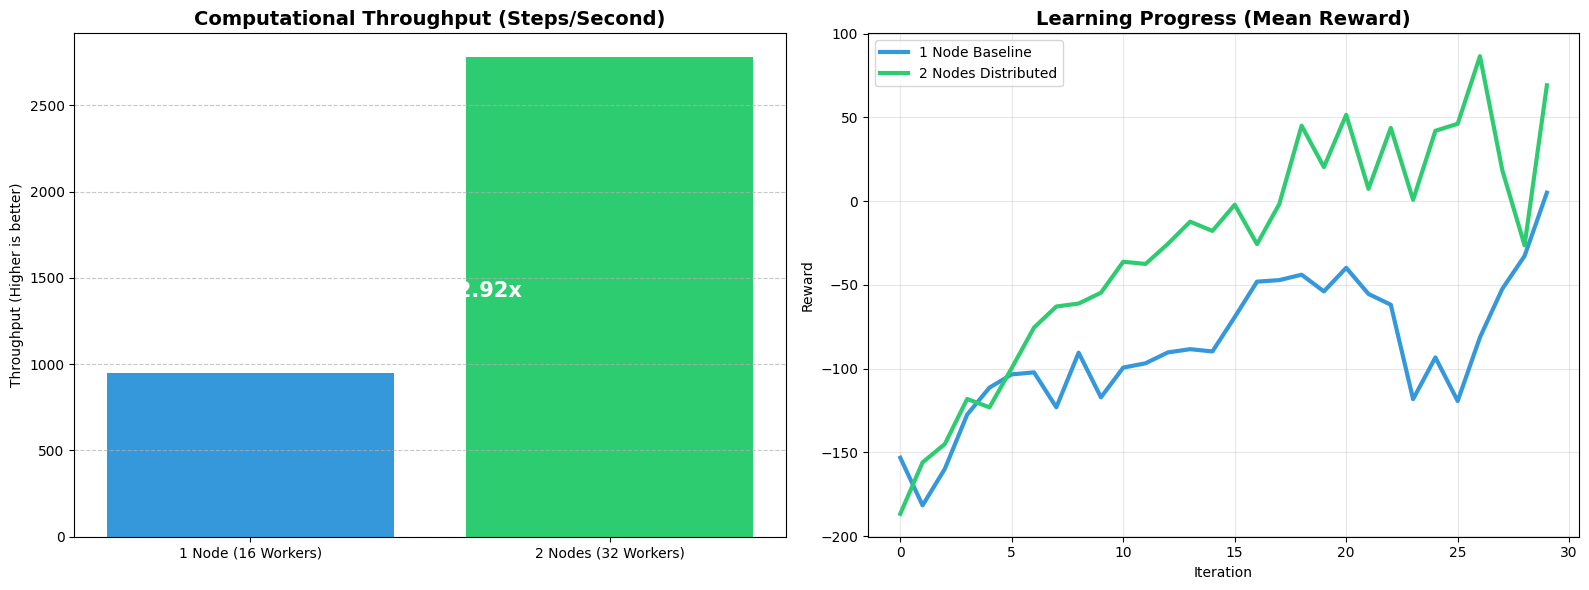

CONCLUSION: Using 2 nodes resulted in a 2.92x increase in processing speed.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_csv("baseline_1node.csv")
df2 = pd.read_csv("scaling_2nodes_final.csv")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

avg_speed1 = df1['throughput'].iloc[5:].mean()
avg_speed2 = df2['throughput'].iloc[5:].mean()

ax1.bar(['1 Node (16 Workers)', '2 Nodes (32 Workers)'], [avg_speed1, avg_speed2], color=['#3498db', '#2ecc71'])
ax1.set_title('Computational Throughput (Steps/Second)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Throughput (Higher is better)')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

speedup = avg_speed2 / avg_speed1
ax1.text(0.5, avg_speed2 * 0.5, f"Speedup: {speedup:.2f}x", ha='center', fontsize=15, fontweight='bold', color='white')

ax2.plot(df1['iter'], df1['reward'], label='1 Node Baseline', color='#3498db', linewidth=3)
ax2.plot(df2['iter'], df2['reward'], label='2 Nodes Distributed', color='#2ecc71', linewidth=3)
ax2.set_title('Learning Progress (Mean Reward)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Reward')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("hpc_comparison_results.png")
plt.show()

print(f"CONCLUSION: Using 2 nodes resulted in a {speedup:.2f}x increase in processing speed.")